# DATA PREPROCESSING POCKETQUEST
This Jupyter notebook contains the code for all of the data preprocessing steps of our project. 

As a first step our goal is to get the PDB files of the complexes from the RCSB public API

In [ ]:
# === LIBRARIES ===
import os
import time
import pandas as pd
import requests
from requests.exceptions import RequestException

# === PARAMETERS ===
input_file = "BindingDB_BindingDB_Articles.tsv" #Downloaded from LigandDB 
pdb_column = "PDB ID(s) for Ligand-Target Complex" #We want to get the PDB IDs of the protein-ligand article curated complexes
output_dir = "PDB_Files"
max_pdbs = 4000 #Limit to 4K because of computational costs 
retry_limit = 3
delay_between_downloads = 0.2  

# === READ BINDINGDB TSV FILE ===
print("Reading TSV...")
df = pd.read_csv(input_file, sep="\t", on_bad_lines="skip", low_memory=False)

if pdb_column not in df.columns:
    print(f"Column '{pdb_column}' not found.")
    exit()

# Keep only rows that have a non-empty PDB ID
df = df[df[pdb_column].notna() & (df[pdb_column].str.strip() != "")]

# === EXTRACT 4000 UNIQUE PDB IDs ===
print("Extracting unique PDB IDs...")
unique_pdbs = set()

for ids in df[pdb_column]:
    for pdb_id in str(ids).replace(',', ';').split(';'):
        pdb_id = pdb_id.strip().upper()
        if pdb_id and pdb_id not in unique_pdbs:
            unique_pdbs.add(pdb_id)
            if len(unique_pdbs) == max_pdbs:
                break
    if len(unique_pdbs) == max_pdbs:
        break

print(f"Collected {len(unique_pdbs)} unique PDB IDs.")

# === CREATE OUTPUT FOLDER ===
os.makedirs(output_dir, exist_ok=True)

# === DOWNLOAD PDB FILES WITH RETRIES ===
#In this part a lot of log messages where directed in the stdout so we know how the connection with the API and download process are going
print("Starting download of PDB files...")
for pdb_id in unique_pdbs:
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    dest_file = os.path.join(output_dir, f"{pdb_id}.pdb")

    if os.path.exists(dest_file):
        print(f"Skipped (already exists): {pdb_id}.pdb")
        continue

    for attempt in range(1, retry_limit + 1):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                with open(dest_file, "w") as f:
                    f.write(response.text)
                print(f"Downloaded: {pdb_id}.pdb")
                break  # success
            else:
                print(f"HTTP error {response.status_code} for {pdb_id}")
                break  # do not retry on bad status
        except RequestException as e:
            print(f"Retry {attempt}/{retry_limit} for {pdb_id} — {e}")
            time.sleep(2)
    else:
        print(f"Failed after {retry_limit} attempts: {pdb_id}")

    time.sleep(delay_between_downloads)

# === SAVE DOWNLOADED LIST ===
with open("downloaded_pdbs.txt", "w") as f:
    for pdb in sorted(unique_pdbs):
        f.write(pdb + "\n")              #useful to get all the PDB codes of the downloaded PDBs on a list

print(f"\n All downloads completed. Files saved in '{output_dir}/'")



This long code block that follows achieves Ligand Identification, Binding Site Extraction & Filtering

In [ ]:

# === LIBRARIES ===
import os
import pandas as pd
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.distances import distance_array
from collections import defaultdict, Counter
from Bio.SeqUtils import seq1

# === LOGGING ===
log_file = open("ligand_detection_log.txt", "w") ##Very very important, in the very end of the log there are some stats of the filtering process too
def log(msg):
    print(msg)
    log_file.write(msg + "\n")

# === PARAMETERS ===
pdb_folder = "PDB_Files"
output_csv = "binding_sites.csv" #This will contain the binding sites of each pdb code per ligand and they are going to be specified by residue type number and chain e.g. ASN_253_A
distance_cutoff = 4.0  # Known Angstrom distance used in literature to define Binding Sites
centroid_distance_cutoff = 4.0  # Å for centroid-based merging, used in merging very close bs into one

# === Full exclusion list ===
exclude_resnames = {
    # Standard amino acids
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL", "SEC", "PYL",

    # Nucleotides
    "DA", "DG", "DC", "DT", "DI", "A", "G", "C", "U", "I",

    # Water and common ions
    "HOH", "WAT", "DOD", "CL", "NA", "K", "CA", "MG", "MN", "FE", "ZN", "CU", "CD", "CO",
    "SO4", "NO3", "CO3", "BO4", "SCN", "IOD", "BR", "F", "IO3",

    # Sugars and glycans
    "NAG", "MAN", "BMA", "FUC", "NDG", "GLC", "GAL", "SUC", "TRE", "FRU",

    # Ions and metals
    "SE", "KR", "NI", "AS", "D", "YB", "RU", "HG", "HG2", "LI", "BA", "SR", "RA", "AL",
    "PB", "BI", "SN", "SB", "CS", "U",

    # Unspecified/ambiguous (keep excluding UNK due to modified ligands default)
    "UNK"
}


# === IDENTIFY HOMOMERIC CHAINS (REMOVE EXCEPT IF HOLDING UNIQUE LIGAND) ===
alt_resname_map = {
    "HSD": "HIS", "HSE": "HIS", "HIP": "HIS",
    "MSE": "MET"
}  #this is very useful because some amino acids if specified by their second name e.g. HSD instead of HIS they are sometimes identified as HETATM (heteroatoms) and not part of the protein

valid_aa_3letter = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "HSD", "HSE", "HIP",
    "ILE", "LEU", "LYS", "MET", "MSE",
    "PHE", "PRO", "SER", "THR",
    "TRP", "TYR", "VAL", "SEC", "PYL"
}

def get_chain_sequence(residues):
    sequence = []
    for res in residues:
        resname = res.resname
        if resname in valid_aa_3letter:
            canonical = alt_resname_map.get(resname, resname)
            try:
                sequence.append(seq1(canonical))
            except Exception:
                continue
    return "".join(sequence) #We define as homomeric the chains that have identical sequence inside a PDB File

def identify_unique_chain_ids(universe, ligand_residues=None, distance_cutoff=4.0):
    from Bio import pairwise2

    seen_sequences = []
    ligand_counts = Counter(res.resname for res in ligand_residues) if ligand_residues else Counter()
    singleton_ligands = {res for res, count in ligand_counts.items() if count == 1} #singleton ligands are ligands that only bind in one chain
    ligand_nearby_chains = set()

    if ligand_residues:
        for ligand_res in ligand_residues:
            if ligand_res.resname not in singleton_ligands:
                continue
            ligand_atoms = ligand_res.atoms
            for seg in universe.segments:
                seg_atoms = seg.atoms.select_atoms("protein and not name H*")
                if len(seg_atoms) == 0:
                    continue
                try:
                    dists = distance_array(ligand_atoms.positions, seg_atoms.positions)
                    if np.any(dists < distance_cutoff):
                        ligand_nearby_chains.add(seg.segid)
                except Exception:
                    continue

    unique_chain_ids = []
    for seg in universe.segments:
        seq = get_chain_sequence(seg.residues)
        if not seq:
            continue
        is_duplicate = False
        for seen_seq in seen_sequences:
            alignments = pairwise2.align.globalxx(seq, seen_seq)
            identity = alignments[0][2] / max(len(seq), len(seen_seq))
            if identity >= 0.99:
                is_duplicate = True
                break
        if not is_duplicate or seg.segid in ligand_nearby_chains:
            seen_sequences.append(seq)
            unique_chain_ids.append(seg.segid)
    return unique_chain_ids

# === FINAL FILTERING ===

#We apply two basic rules among others in this filtering:
#If 2 binding sites of the same pdb correspond to the same ligand and have 70% identity or more we collapse them in one because some of these structures contain small molecules that are more than one in the file
#If 2 binding sites of the same pdb correspond to the same ligand and don't hvae 70% or more identity but their centroids are closer than 4 Angstroms we also collapse them in one binding site.


def compute_binding_site_centroid(universe, residues):
    atoms = universe.select_atoms(" or ".join([
        f"(resname {res.split('_')[0]} and resid {res.split('_')[1]})"
        for res in residues
    ]))
    if len(atoms) == 0:
        return None
    return atoms.positions.mean(axis=0)

def remove_redundant_sites(results, pdb_folder, overlap_thresh=0.7):
    grouped = defaultdict(list)
    for entry in results:
        key = (entry["pdb_id"], entry["ligand"])
        grouped[key].append(entry)

    filtered = []

    for (pdb_id, ligand), sites in grouped.items():
        pdb_path = os.path.join(pdb_folder, f"{pdb_id}.pdb")
        try:
            u = mda.Universe(pdb_path)
        except Exception as e:
            log(f"Error loading {pdb_id}: {e}")
            continue

        kept_sites = []

        for site in sites:
            current_set = set(site["binding_residues"].split(";"))
            merged = False

            for kept in kept_sites:
                kept_set = set(kept["binding_residues"].split(";"))
                intersection = current_set & kept_set
                overlap = len(intersection) / min(len(current_set), len(kept_set))

                if overlap >= overlap_thresh:
                    kept["binding_residues"] = ";".join(sorted(current_set | kept_set))
                    merged = True
                    break

                disjoint_current = current_set - kept_set
                disjoint_kept = kept_set - current_set

                if disjoint_current and disjoint_kept:
                    centroid1 = compute_binding_site_centroid(u, disjoint_current)
                    centroid2 = compute_binding_site_centroid(u, disjoint_kept)
                    if centroid1 is not None and centroid2 is not None:
                        dist = np.linalg.norm(centroid1 - centroid2)
                        if dist <= centroid_distance_cutoff:
                            kept["binding_residues"] = ";".join(sorted(current_set | kept_set))
                            merged = True
                            break

            if not merged:
                kept_sites.append(site)

        filtered.extend(kept_sites)

    return filtered
#We only keep two ligands per pdb that have the bigger number of atoms (trying to discard non biologically relevant ligands)
def keep_top_two_ligands(results):
    final_results = []
    grouped = defaultdict(list)
    for entry in results:
        grouped[entry["pdb_id"]].append(entry)
    for pdb_id, entries in grouped.items():
        top_two = sorted(entries, key=lambda x: x["n_residues"], reverse=True)[:2]
        final_results.extend(top_two)
    return final_results

# === MAIN LOOP ===
results = []
for filename in os.listdir(pdb_folder):
    if not filename.endswith(".pdb"):
        continue

    pdb_id = filename[:4].upper()
    pdb_path = os.path.join(pdb_folder, filename)

    try:
        u = mda.Universe(pdb_path)

        all_ligand_atoms = u.select_atoms(
            f"not protein and not resname {' '.join(exclude_resnames)} and not name H*"
        )
        ligand_residues = [res for res in all_ligand_atoms.residues if len(res.atoms) >= 5] #We discard all possible ligands with less than 5 atoms

        if not ligand_residues:
            log(f"No valid ligand found in {pdb_id}")
            continue

        unique_chain_ids = identify_unique_chain_ids(u, ligand_residues=ligand_residues)
        protein_atoms = u.select_atoms(f"protein and segid {' '.join(unique_chain_ids)} and not name H*")

        if len(protein_atoms) == 0:
            log(f"No protein atoms found in {pdb_id}")
            continue
        #Now we will get all residues close to the ligands (bs residues)
        for ligand_res in ligand_residues:
            ligand_atoms = ligand_res.atoms
            dists = distance_array(ligand_atoms.positions, protein_atoms.positions)
            close_contacts = (dists < distance_cutoff)

            close_atom_indices = {
                protein_atoms[j].index
                for i in range(close_contacts.shape[0])
                for j in range(close_contacts.shape[1])
                if close_contacts[i, j]
            }

            binding_residues = {
                f"{u.atoms[idx].residue.resname}_{u.atoms[idx].residue.resid}_{u.atoms[idx].residue.segid}"
                for idx in close_atom_indices
            }

            if len(binding_residues) < 5:
                continue

            results.append({
                "pdb_id": pdb_id,
                "ligand": ligand_res.resname,
                "ligand_resid": ligand_res.resid,
                "binding_residues": ";".join(sorted(binding_residues)),
                "n_residues": len(binding_residues)
            })

            log(f"{pdb_id} | Ligand: {ligand_res.resname} {ligand_res.resid} | Residues: {len(binding_residues)}")

    except Exception as e:
        log(f"Failed for {pdb_id}: {e}")
        continue

# === RUN FINAL FILTERS AND SAVE ===
filtered_results = remove_redundant_sites(results, pdb_folder)
filtered_results = keep_top_two_ligands(filtered_results)

pd.DataFrame(filtered_results).to_csv(output_csv, index=False)

# === REPORTING ===
log(f"Total initial sites: {len(results)}")
log(f"Total after filtering: {len(filtered_results)}")

#This will be written in the log!!

if filtered_results:
    df = pd.DataFrame(filtered_results)
    log(f"Average residues per site: {df['n_residues'].mean():.2f}")
    log(f"Max residues per site: {df['n_residues'].max()}")
    log(f"Min residues per site: {df['n_residues'].min()}")
    most_common_ligands = df['ligand'].value_counts().head(5)
    log("Top 5 ligands:")
    for lig, count in most_common_ligands.items():
        log(f"  {lig}: {count}")

log(f"Done! Results saved to {output_csv}")
log_file.close()


We are trying to classify our PDBs into general protein groups to see what our dataset contains. The best way to do this was to get Uniprot IDs and then PANTHER Classifications. 

In [ ]:
import requests
import pandas as pd
import time

# Input and output file paths
input_csv = "binding_sites.csv"  
output_csv = "pdb_uniprot_mapping.csv" #important file so then we can do the pdb to panther mapping

# Read input CSV
df = pd.read_csv(input_csv)
if 'pdb_id' not in df.columns:
    raise ValueError("Column 'pdb_id' not found in the input CSV")

# Get unique PDB IDs, we first inspected what is the structure of the array returned by the API in order to get the following code correct
unique_pdb_ids = df['pdb_id'].dropna().unique()

def fetch_uniprot_ids(pdb_id):
    url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id.lower()}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data for {pdb_id}")
        return []

    data = response.json()
    entity_ids = data.get("rcsb_entry_container_identifiers", {}).get("polymer_entity_ids", [])
    uniprot_ids = set()

    for entity_id in entity_ids:
        entity_url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id.lower()}/{entity_id}"
        entity_resp = requests.get(entity_url)
        if entity_resp.status_code != 200:
            continue

        entity_data = entity_resp.json()
        ref_ids = entity_data.get("rcsb_polymer_entity_container_identifiers", {}).get("reference_sequence_identifiers", [])
        for ref in ref_ids:
            if ref.get("database_name") == "UniProt":
                uniprot_ids.add(ref.get("database_accession"))

    return list(uniprot_ids)


# Process each PDB ID
output_rows = []
for pdb_id in unique_pdb_ids:
    uniprot_ids = fetch_uniprot_ids(pdb_id)
    if uniprot_ids:
        output_rows.append({"PDB_ID": pdb_id.upper(), "UniProt_IDs": "; ".join(uniprot_ids)})
        print(f"✅ {pdb_id}: Found UniProt IDs: {', '.join(uniprot_ids)}")
    else:
        print(f"{pdb_id}: No UniProt IDs found")
    time.sleep(0.1)  # To avoid overwhelming the server

# Save results to CSV
if output_rows:
    out_df = pd.DataFrame(output_rows)
    out_df.to_csv(output_csv, index=False)
    print(f"Saved UniProt mappings to {output_csv}")
else:
    print("No UniProt IDs were found for any PDB entries.")


✅ 1BVE: Found UniProt IDs: P04585
✅ 7ODP: Found UniProt IDs: Q5F6E9
✅ 3T3C: Found UniProt IDs: P03367
✅ 1RMY: Found UniProt IDs: P0AE22
✅ 1OZ0: Found UniProt IDs: P31335
✅ 2F27: Found UniProt IDs: Q9Y3R4
✅ 1R8E: Found UniProt IDs: P39075
✅ 1I9L: Found UniProt IDs: P00918
✅ 7DQF: Found UniProt IDs: P0AES6
✅ 5ZHP: Found UniProt IDs: P08483, P00720
✅ 1SXU: Found UniProt IDs: Q94734
✅ 1XH8: Found UniProt IDs: P61925, P00517
✅ 5K5D: Found UniProt IDs: D0KSP7
✅ 1OZG: Found UniProt IDs: P27696
✅ 3CIT: Found UniProt IDs: Q884G2
✅ 2HJ0: Found UniProt IDs: Q8DUC1
✅ 1PCR: Found UniProt IDs: P0C0Y9, P0C0Y7, P0C0Y8
✅ 6B1D: Found UniProt IDs: Q6VT83
✅ 5QEK: Found UniProt IDs: P18031
✅ 5NW8: Found UniProt IDs: P25321, G3HK48
✅ 3TI5: Found UniProt IDs: C3W5S3
✅ 1XDH: Found UniProt IDs: P46925
✅ 4HZX: Found UniProt IDs: A9YN63
✅ 227L: Found UniProt IDs: P00720
✅ 5H2U: Found UniProt IDs: Q13882
✅ 2G00: Found UniProt IDs: P00742
✅ 2J51: Found UniProt IDs: Q9H2G2
✅ 1O3O: Found UniProt IDs: P00760
✅ 4WO0: 

After this step all UniprotIDs found were saved on a list, that was uploaded in PANTHER for classification. PANTHER Classification results were saved in a file called pantherGeneList (1).txt that contained the information needed in a speficif format. The following code block extracts thi info from this file in order to stratify our first batches.

In [ ]:
import pandas as pd
import re

# === Load Panther Classification File ===
panther_df = pd.read_csv("pantherGeneList (1).txt", sep="\t", dtype=str)

# Extract UniProt ID and Panther Protein Class
panther_df = panther_df.iloc[:, [1, 4]]
panther_df.columns = ["UniProt_ID", "Panther_Protein_Class"]

# Extract Panther code and clean class name
panther_df["Panther_Code"] = panther_df["Panther_Protein_Class"].apply(
    lambda x: re.search(r"\(PC\d+\)", x).group(0).strip("()") if pd.notnull(x) and re.search(r"\(PC\d+\)", x) else None
)
panther_df["Panther_Protein_Class"] = panther_df["Panther_Protein_Class"].apply(
    lambda x: re.sub(r"\(PC\d+\)", "", x).strip() if pd.notnull(x) else x
)

# Drop duplicates
panther_df = panther_df.drop_duplicates()

# === Load PDB–UniProt Mapping ===
pdb_uniprot_df = pd.read_csv("pdb_uniprot_mapping.csv")

# === Merge and remove non-matches ===
merged = pdb_uniprot_df.merge(
    panther_df, how="left", left_on="UniProt_IDs", right_on="UniProt_ID"
)

# Remove rows with no Panther match
merged = merged.dropna(subset=["Panther_Protein_Class", "Panther_Code"])

# === Select and export columns ===
final_df = merged[["PDB_ID", "Panther_Protein_Class", "Panther_Code"]].drop_duplicates()
final_df.to_csv("pdb_to_panther_filtered.csv", index=False)

print("Saved 'pdb_to_panther_filtered.csv' with only PDBs mapped to Panther classes.")


✅ Saved 'pdb_to_panther_filtered.csv' with only PDBs mapped to Panther classes.


At this point we have PANTHER Classifications matched to our PDB IDs and we can check the distribution of different classes inside our dataset. We can also get the counts of each protein group.

In [ ]:
import pandas as pd
from collections import Counter

# Load the filtered mapping file
df = pd.read_csv("pdb_to_panther_filtered.csv")

# Count occurrences of each protein class
counts = df["Panther_Protein_Class"].value_counts().reset_index()
counts.columns = ["Panther_Protein_Class", "Count"]

# Save to CSV
counts.to_csv("panther_class_counts.csv", index=False)

print("Saved counts to 'panther_class_counts.csv'")


✅ Saved counts to 'panther_class_counts.csv'


In the end, we only want to know what our data represent and so we want to discard from all our downloaded PDBs the ones that did not hold a PANTHER Classification. 

In [ ]:
import pandas as pd
import shutil
import os

# === File and folder paths ===
filtered_csv = "pdb_to_panther_filtered.csv"
source_folder = "Final_PDBs"
destination_folder = "After_Panther"

# === Read PDB IDs from filtered CSV ===
df = pd.read_csv(filtered_csv)
pdb_ids = df["PDB_ID"].dropna().unique()

# === Copy matching PDB files ===
copied = 0
for pdb_id in pdb_ids:
    pdb_filename = f"{pdb_id.upper()}.pdb"
    source_path = os.path.join(source_folder, pdb_filename)
    dest_path = os.path.join(destination_folder, pdb_filename)
    
    if os.path.exists(source_path):
        shutil.copy(source_path, dest_path)
        copied += 1
        print(f"Copied: {pdb_filename}")
    else:
        print(f"Not found: {pdb_filename}")

print(f"\nFinished copying {copied} PDB files to '{destination_folder}'")


✅ Copied: 2F27.pdb
✅ Copied: 1R8E.pdb
✅ Copied: 1I9L.pdb
✅ Copied: 7DQF.pdb
✅ Copied: 5QEK.pdb
✅ Copied: 5H2U.pdb
✅ Copied: 2G00.pdb
✅ Copied: 2J51.pdb
✅ Copied: 1O3O.pdb
✅ Copied: 4WO0.pdb
✅ Copied: 1AKY.pdb
✅ Copied: 4LUE.pdb
✅ Copied: 4NDI.pdb
✅ Copied: 1I91.pdb
✅ Copied: 1HVY.pdb
✅ Copied: 2JFL.pdb
✅ Copied: 2HW7.pdb
✅ Copied: 2HE5.pdb
✅ Copied: 1NG4.pdb
✅ Copied: 3NPC.pdb
✅ Copied: 1A9P.pdb
✅ Copied: 5JIZ.pdb
✅ Copied: 1ALH.pdb
✅ Copied: 1ZFQ.pdb
✅ Copied: 1T96.pdb
✅ Copied: 2G8N.pdb
✅ Copied: 1X70.pdb
✅ Copied: 1LPG.pdb
✅ Copied: 7OFP.pdb
✅ Copied: 5VCX.pdb
✅ Copied: 1GII.pdb
✅ Copied: 8EYO.pdb
✅ Copied: 5MUG.pdb
✅ Copied: 3HOF.pdb
✅ Copied: 5WIN.pdb
✅ Copied: 5G65.pdb
✅ Copied: 1KE4.pdb
✅ Copied: 3RI3.pdb
✅ Copied: 1TRN.pdb
✅ Copied: 1BIF.pdb
✅ Copied: 3DAZ.pdb
✅ Copied: 1ANI.pdb
✅ Copied: 7DQU.pdb
✅ Copied: 1CY7.pdb
✅ Copied: 1TDU.pdb
✅ Copied: 1O93.pdb
✅ Copied: 1S3B.pdb
✅ Copied: 3H73.pdb
✅ Copied: 4KX3.pdb
✅ Copied: 4LU3.pdb
✅ Copied: 1BNV.pdb
✅ Copied: 1VCU.pdb
✅ Copied: 3C

Now we can plot the Panther Protein Class Distribution to see what our dataset actually contains

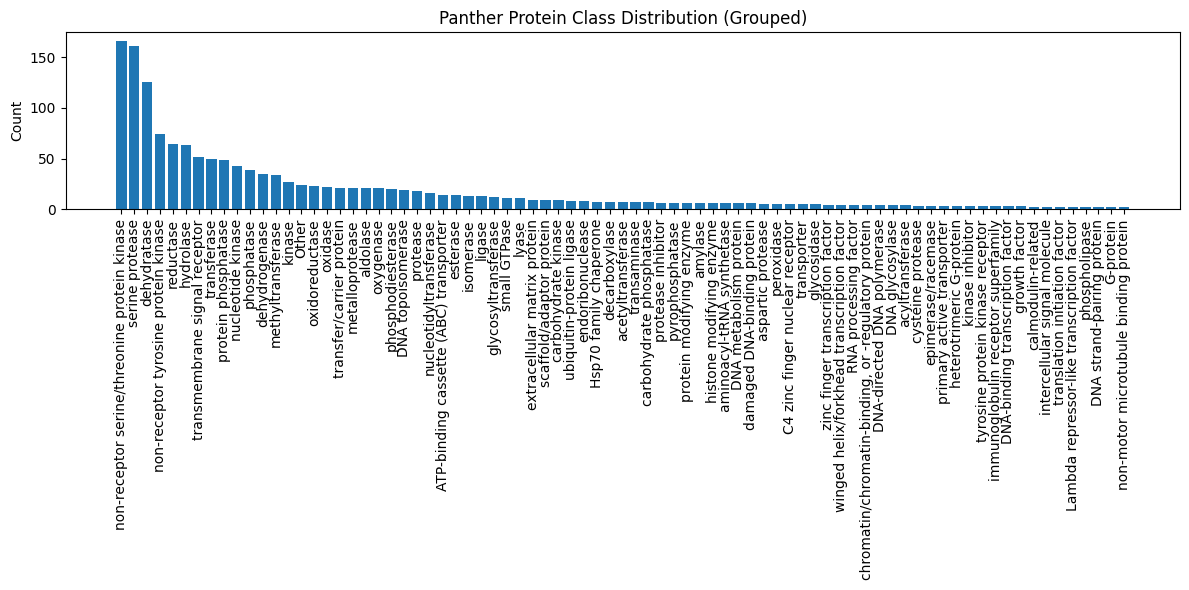

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === Load the filtered Panther mapping ===
df = pd.read_csv("pdb_to_panther_filtered.csv")

# === Count occurrences of each class ===
counts = Counter(df["Panther_Protein_Class"].dropna())

# === Group classes with count == 1 as 'Other' === 
#We had a big number of different classes with only one count so we grouped them in another group called 'other'
grouped_counts = {}
other_total = 0

for class_name, count in counts.items():
    if count == 1:
        other_total += 1
    else:
        grouped_counts[class_name] = count

if other_total > 0:
    grouped_counts["Other"] = other_total

# === Convert to DataFrame and sort ===
plot_df = pd.DataFrame(list(grouped_counts.items()), columns=["Panther_Protein_Class", "Count"])
plot_df = plot_df.sort_values(by="Count", ascending=False)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.bar(plot_df["Panther_Protein_Class"], plot_df["Count"])
plt.xticks(rotation=90)
plt.title("Panther Protein Class Distribution (Grouped)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("panther_class_distribution.png")
plt.show()


For handling better next steps, we decided to create 15 batches of these PDBs that are stratified and contain more or less the same percentage of different protein classes

In [ ]:
import pandas as pd
import random
import os

# === Load Panther filtered annotations ===
df = pd.read_csv("pdb_to_panther_filtered.csv")

# === Optional: Only keep existing PDBs ===
pdb_folder = "After_Panther"
existing_pdbs = set(f.replace(".pdb", "") for f in os.listdir(pdb_folder) if f.endswith(".pdb"))
df = df[df["PDB_ID"].isin(existing_pdbs)]

# === Group PDBs by Panther class and shuffle ===
grouped = df.groupby("Panther_Protein_Class")
shuffled_pdbs = []

for _, group in grouped:
    pdbs = list(group["PDB_ID"])
    random.shuffle(pdbs)
    shuffled_pdbs.extend(pdbs)

# === Final shuffle for randomness across classes ===
random.shuffle(shuffled_pdbs)

# === Split into 15 nearly equal batches ===
num_batches = 15
batch_size = len(shuffled_pdbs) // num_batches
remainder = len(shuffled_pdbs) % num_batches

batches = []
start = 0
for i in range(num_batches):
    size = batch_size + (1 if i < remainder else 0)
    batch = shuffled_pdbs[start:start+size]
    batches.append(batch)
    start += size

# === Save each batch ===
for i, batch in enumerate(batches):
    df_batch = pd.DataFrame(batch, columns=["PDB_ID"])
    df_batch.to_csv(f"batch_{i+1}_balanced.csv", index=False)
    print(f"Saved batch_{i+1}_balanced.csv with {len(batch)} PDBs")


✅ Saved batch_1_balanced.csv with 102 PDBs
✅ Saved batch_2_balanced.csv with 102 PDBs
✅ Saved batch_3_balanced.csv with 102 PDBs
✅ Saved batch_4_balanced.csv with 101 PDBs
✅ Saved batch_5_balanced.csv with 101 PDBs
✅ Saved batch_6_balanced.csv with 101 PDBs
✅ Saved batch_7_balanced.csv with 101 PDBs
✅ Saved batch_8_balanced.csv with 101 PDBs
✅ Saved batch_9_balanced.csv with 101 PDBs
✅ Saved batch_10_balanced.csv with 101 PDBs
✅ Saved batch_11_balanced.csv with 101 PDBs
✅ Saved batch_12_balanced.csv with 101 PDBs
✅ Saved batch_13_balanced.csv with 101 PDBs
✅ Saved batch_14_balanced.csv with 101 PDBs
✅ Saved batch_15_balanced.csv with 101 PDBs


Now we will try to plot the distribution of these 15 batches. Note: This was just a trial, these are not the final batches and the correct library that creates distinct colors is not present here. Please continue reading the notebook after this code block

/tmp/ipykernel_21097/2956945629.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

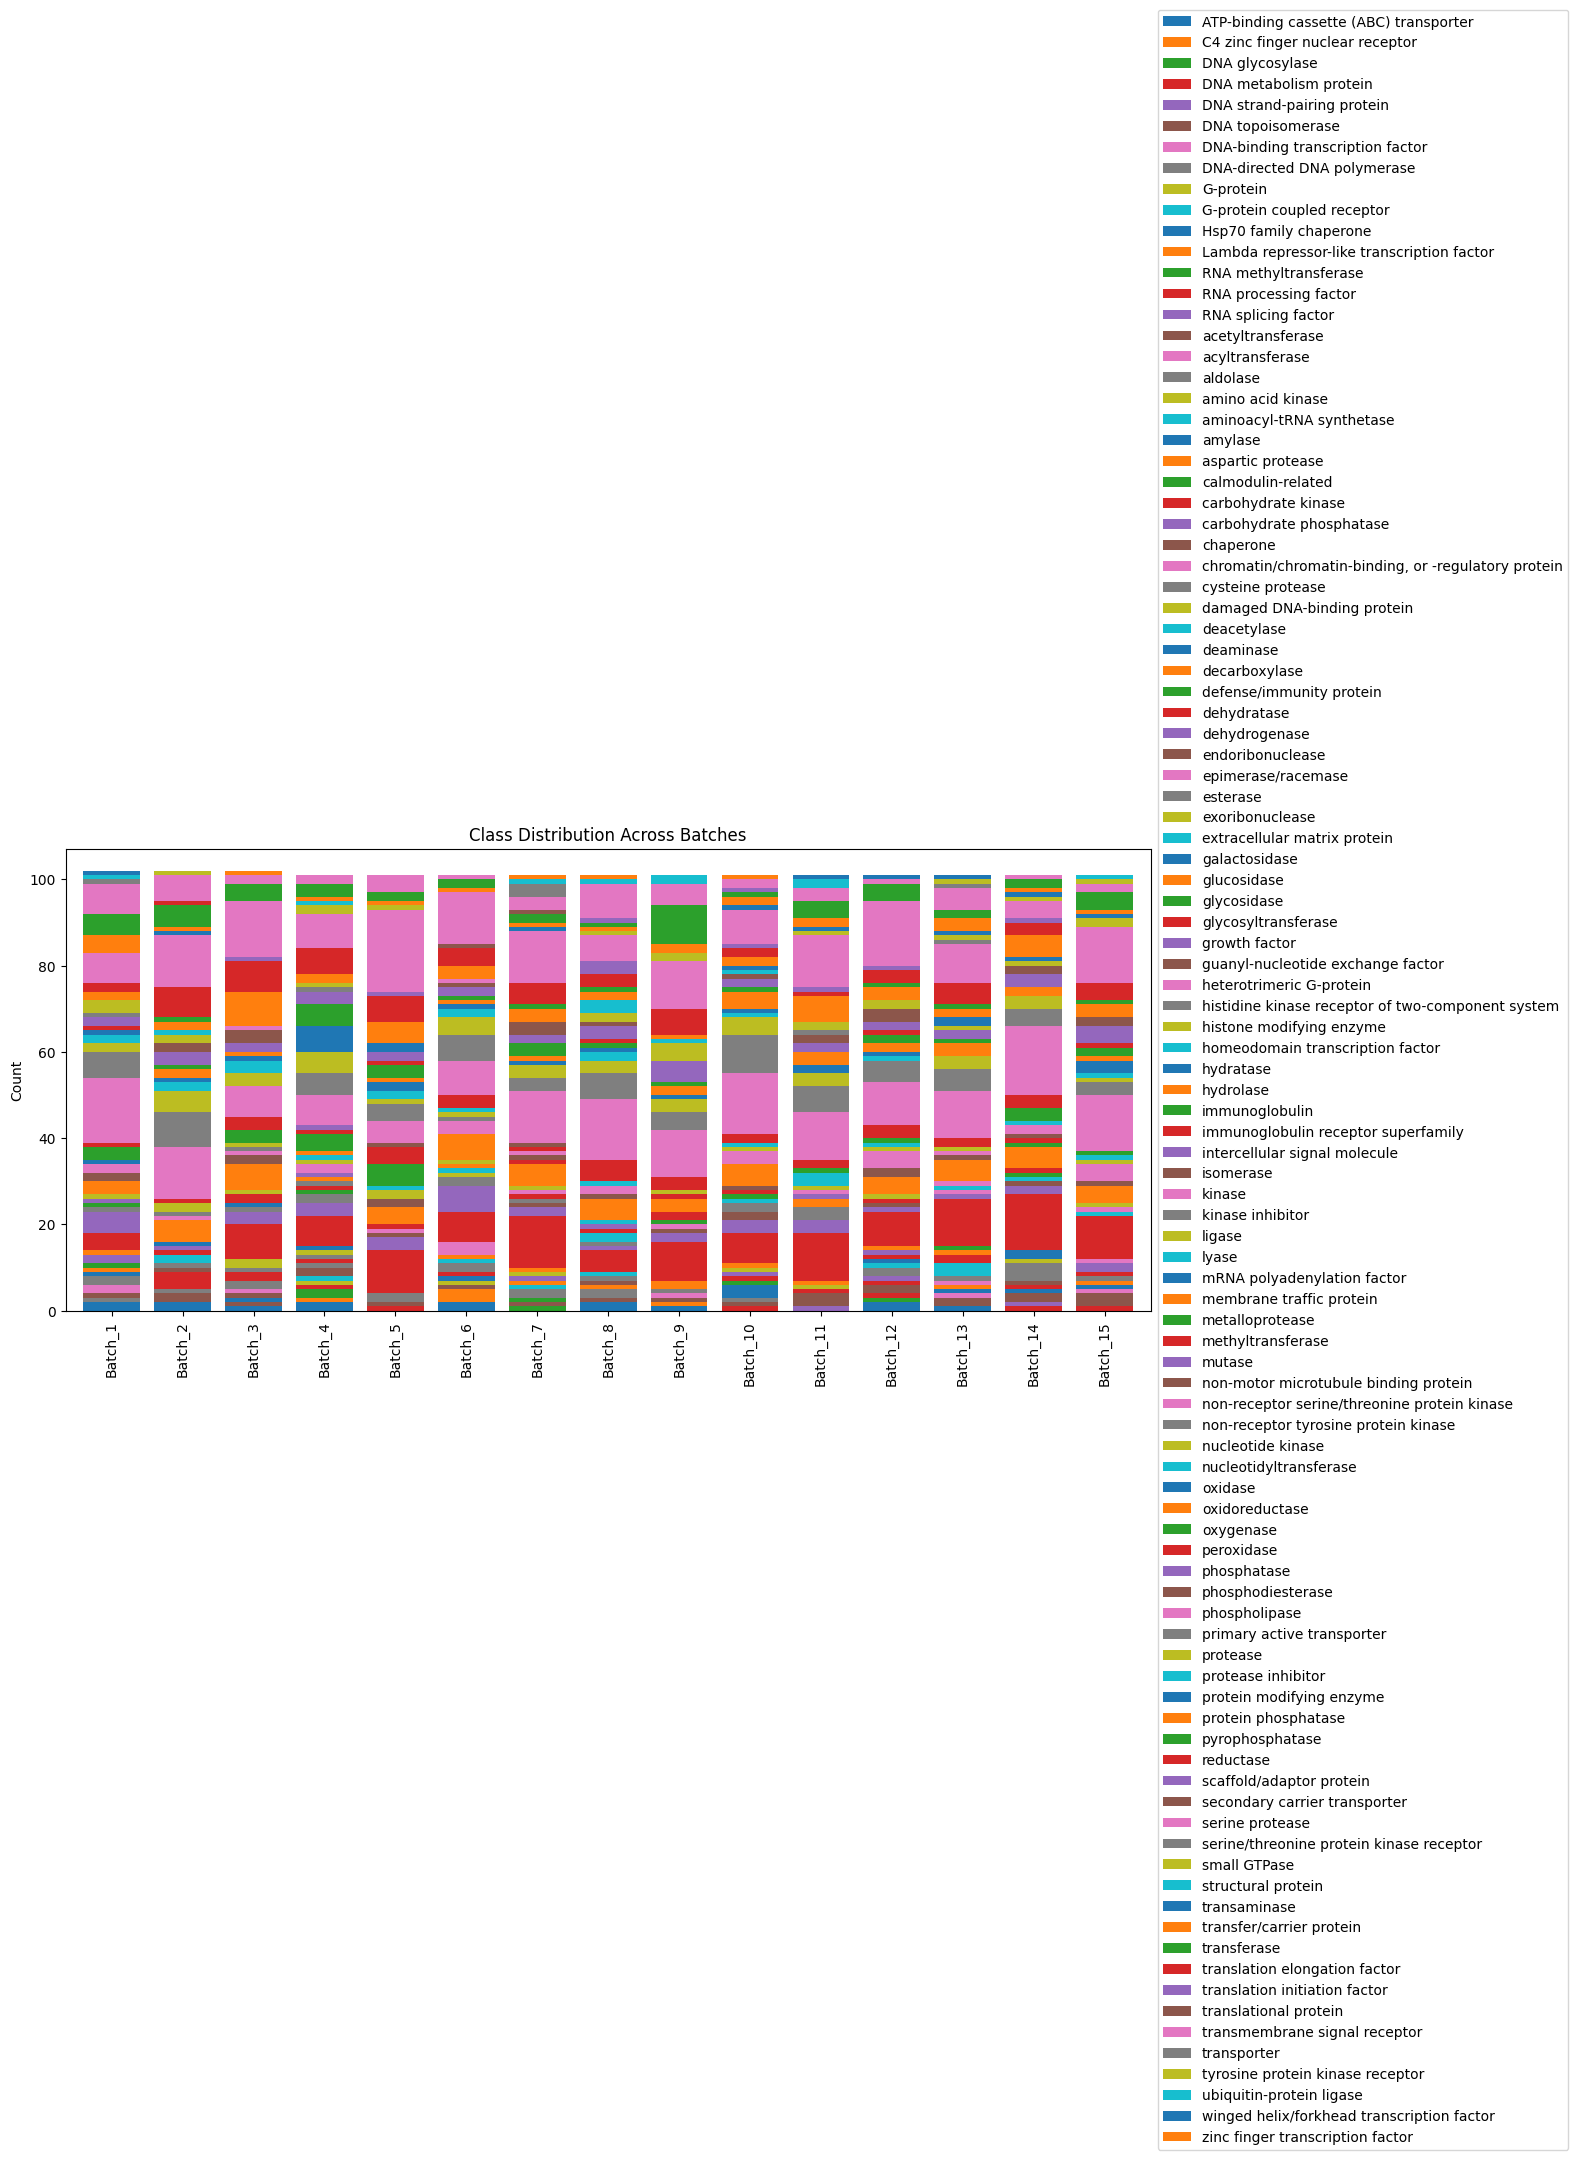

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# === Load the master class annotation ===
df_classes = pd.read_csv("pdb_to_panther_filtered.csv").set_index("PDB_ID")

# === Prepare a summary table ===
summary = {}

for i in range(1, 16):
    batch_file = f"batch_{i}_balanced.csv"
    if not os.path.exists(batch_file):
        print(f"Missing: {batch_file}")
        continue

    df_batch = pd.read_csv(batch_file)
    df_merged = df_batch.merge(df_classes, left_on="PDB_ID", right_index=True)
    class_counts = df_merged["Panther_Protein_Class"].value_counts()
    summary[f"Batch_{i}"] = class_counts

# === Combine to DataFrame and fill missing values ===
summary_df = pd.DataFrame(summary).fillna(0).astype(int)
summary_df = summary_df.sort_index()

# === Plot heatmap-style class distribution ===
plt.figure(figsize=(12, 10))
summary_df.T.plot(kind="bar", stacked=True, figsize=(14, 6), width=0.8)
plt.ylabel("Count")
plt.title("Class Distribution Across Batches")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.savefig("class_distribution_plot.png", dpi=300)


The problem we faced now at this point is that after doing all this filtering and binding site extraction we did not actually check that the binding sites make sense visually. For this reason we decided to create .cmd (Chimera scripts) through Python for each batch in order to load them in Chimera, color differently the ligand and the defined binding site and take a Screenshot. By investigating the screenshots we could actually see if our filtering worked and discard, low quality structures that won't bring a lot of value to the model.

In [ ]:
import pandas as pd
import os

# Folder with batch files
batch_folder = "."
# Folder with PDBs
final_pdbs_dir = os.path.abspath("After_Panther")

# Loop through the 15 batch files
for i in range(1, 16):
    batch_file = f"binding_sites_batch_{i}.csv"
    chimera_cmd_file = f"visualize_batch_{i}.cmd"

    # Load the batch
    df = pd.read_csv(os.path.join(batch_folder, batch_file))

    with open(chimera_cmd_file, "w") as f:
        for index, row in df.iterrows():
            pdb_id = row["pdb_id"]
            ligand = row["ligand"]
            binding_residues = row["binding_residues"].split(";")

            # Path to the corresponding PDB file
            pdb_path = os.path.join(final_pdbs_dir, f"{pdb_id}.pdb")
            f.write(f"open {pdb_path}\n")

            # Color binding residues
            for residue in binding_residues:
                residue_parts = residue.split('_')
                if len(residue_parts) == 3:
                    residue_number, chain = residue_parts[1], residue_parts[2]
                    f.write(f"color magenta :{residue_number}.{chain}\n") #magenta is the binding site
                else:
                    print(f"Skipping invalid residue format: {residue}")

            # Color ligand
            f.write(f"color cyan :{ligand}\n") #sometimes even chimera's algorithms does not find the ligand correctly though but it mostly works well
            # Save image
            f.write(f"copy file {pdb_id}_binding_sites.png\n") #get a screenshot
            # Close all
            f.write("close all\n\n")

    print(f"Chimera script saved: {chimera_cmd_file}")

After this we opened all 15 cmd scripts in Chimera command line and created the visualiazations for all our 1432 PDBs that remained after PANTHER Classification. All images were investigated manually and 1081 most meaningful and correct ones and their PDBs were kept for the model. Because all this Chimera process led to another filtring step we now have to merge these final PDBs from the 15 batches and then restratify them into 10 balanced batches that contain more or less the same percentage of different protein groups.So next step is to get rid of the low quality PDBs we found and wrote in a list called low_quality.txt

In [ ]:
# == Libraries ==
import os
import pandas as pd

#Define paths
low_quality_path = "screenshots/low_quality.txt"
csv_path = "pdb_to_panther_filtered.csv"
after_panther_dir = "After_Panther"
screenshots_dir = "screenshots"

#Parse the low_quality.txt file
batch_to_pdbs = {}
current_batch = None

with open(low_quality_path, "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith("batch_"):
            current_batch = line
            batch_to_pdbs[current_batch] = []
        elif line and current_batch:
            batch_to_pdbs[current_batch].append(line)

low_quality_pdbs = set(pdb for lst in batch_to_pdbs.values() for pdb in lst)

#Filter CSV
if os.path.isfile(csv_path):
    df = pd.read_csv(csv_path)
    original_len = len(df)
    df_filtered = df[~df["PDB_ID"].isin(low_quality_pdbs)]
    df_filtered.to_csv(csv_path, index=False)
    print(f"Removed {original_len - len(df_filtered)} entries from {csv_path}")
else:
    print(f"File not found: {csv_path}")

#Delete PDB files from After_Panther
pdb_deleted = 0
for pdb in low_quality_pdbs:
    pdb_file = os.path.join(after_panther_dir, f"{pdb}.pdb")
    if os.path.exists(pdb_file):
        os.remove(pdb_file)
        pdb_deleted += 1
print(f"🗑️ Deleted {pdb_deleted} PDB files from {after_panther_dir}/")

#Delete screenshots from screenshots/batch_X/
screenshots_deleted = 0
for batch, pdb_list in batch_to_pdbs.items():
    batch_folder = os.path.join(screenshots_dir, batch)
    if not os.path.isdir(batch_folder):
        print(f"Folder not found: {batch_folder}")
        continue
    for pdb in pdb_list:
        image_name = f"{pdb}_binding_sites.png"
        image_path = os.path.join(batch_folder, image_name)
        if os.path.exists(image_path):
            os.remove(image_path)
            screenshots_deleted += 1
print(f"Deleted {screenshots_deleted} screenshot files from {screenshots_dir}/batch_X folders")


✅ Removed 437 entries from pdb_to_panther_filtered.csv
🗑️ Deleted 437 PDB files from After_Panther/
🧹 Deleted 437 screenshot files from screenshots/batch_X folders


After cleaning restratify, 1081 items in total

Now we get the counts again

In [ ]:
import pandas as pd
from collections import Counter

# Load the filtered mapping file
df = pd.read_csv("pdb_to_panther_filtered.csv")

# Count occurrences of each protein class
counts = df["Panther_Protein_Class"].value_counts().reset_index()
counts.columns = ["Panther_Protein_Class", "Count"]

# Save to CSV
counts.to_csv("panther_class_counts.csv", index=False)

print("Saved counts to 'panther_class_counts.csv'")

✅ Saved counts to 'panther_class_counts.csv'


Check the class distribution again

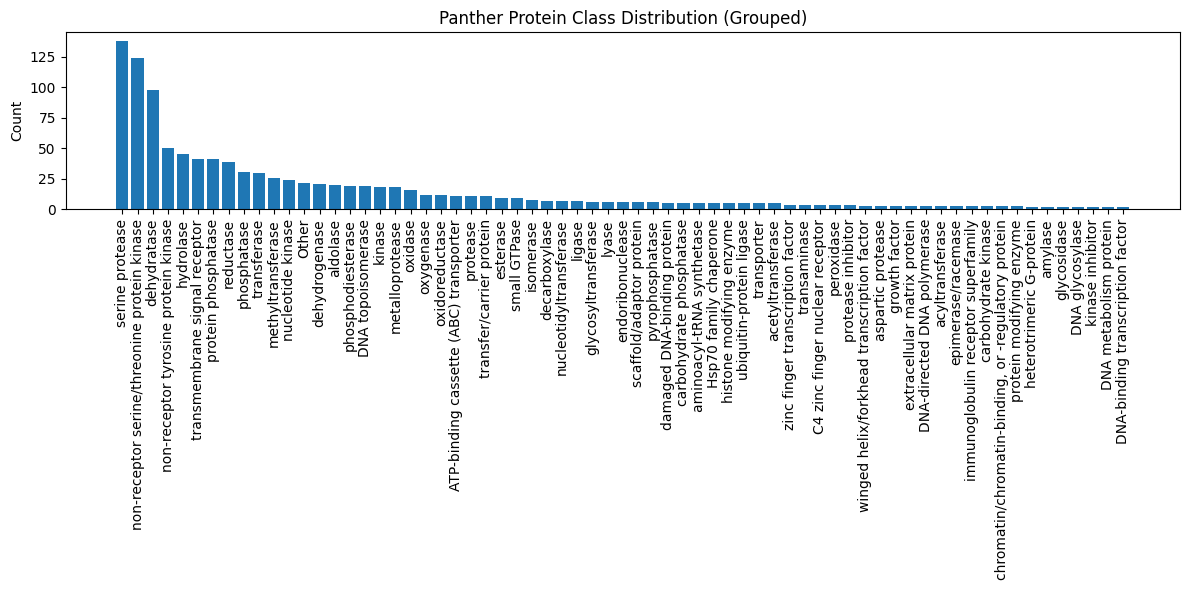

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === Load the filtered Panther mapping ===
df = pd.read_csv("pdb_to_panther_filtered.csv")

# === Count occurrences of each class ===
counts = Counter(df["Panther_Protein_Class"].dropna())

# === Group classes with count == 1 as 'Other' ===
grouped_counts = {}
other_total = 0

for class_name, count in counts.items():
    if count == 1:
        other_total += 1
    else:
        grouped_counts[class_name] = count

if other_total > 0:
    grouped_counts["Other"] = other_total

# === Convert to DataFrame and sort ===
plot_df = pd.DataFrame(list(grouped_counts.items()), columns=["Panther_Protein_Class", "Count"])
plot_df = plot_df.sort_values(by="Count", ascending=False)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.bar(plot_df["Panther_Protein_Class"], plot_df["Count"])
plt.xticks(rotation=90)
plt.title("Panther Protein Class Distribution (Grouped)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("panther_class_distribution.png")
plt.show()

Split in 10 batches and restratify

/home/annie/micromamba/lib/python3.9/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


 Stratified batches saved.


<Figure size 1400x800 with 0 Axes>

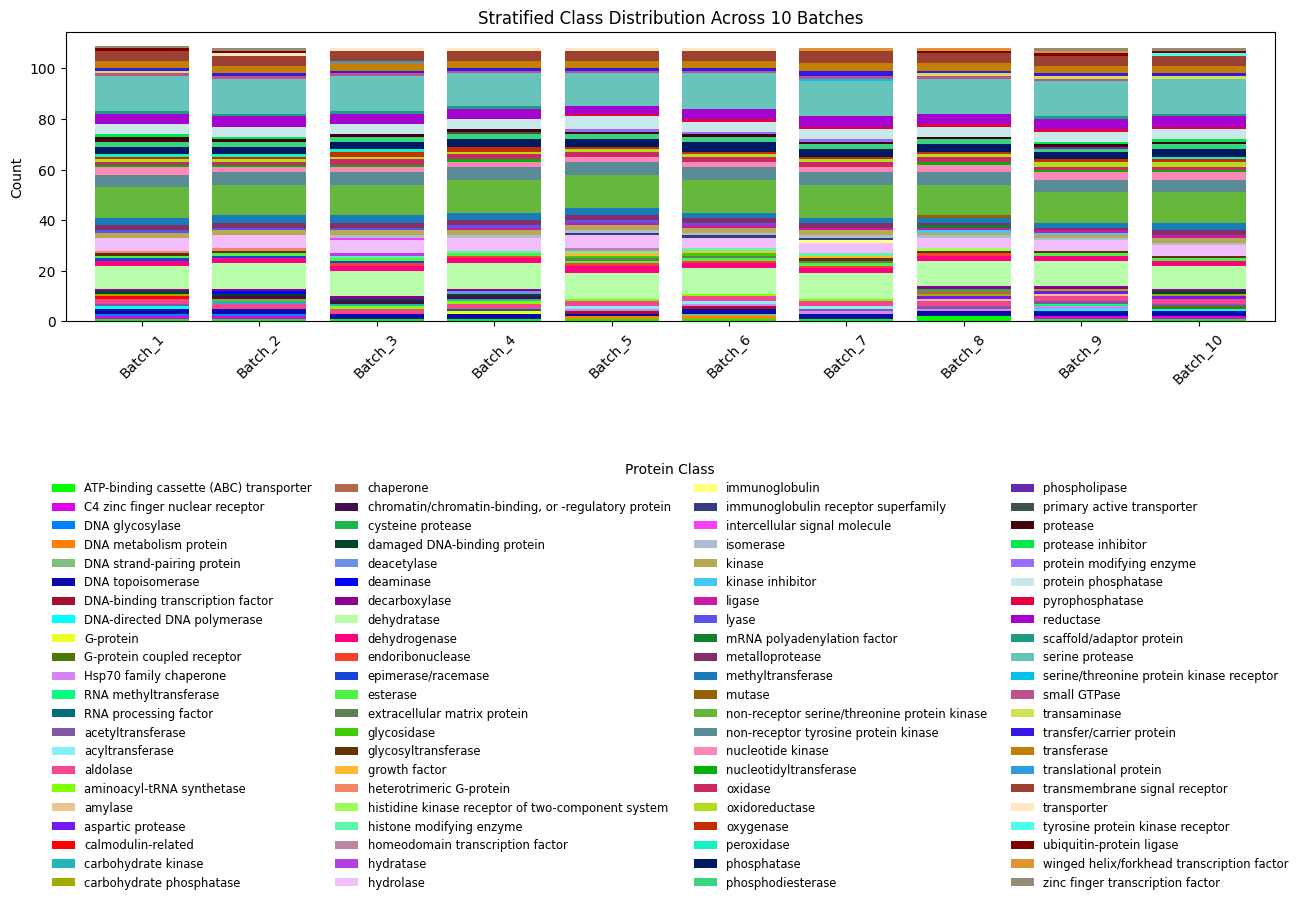

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold

# === Load data ===
df_all = pd.read_csv("pdb_to_panther_filtered.csv")
df_all = df_all.dropna(subset=["Panther_Protein_Class"])  # ensure class exists
df_all = df_all.drop_duplicates(subset="PDB_ID")
df_all = df_all.reset_index(drop=True)

# === Stratified Split into 10 Batches ===
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for i, (_, test_index) in enumerate(skf.split(df_all, df_all["Panther_Protein_Class"]), start=1):
    df_batch = df_all.iloc[test_index]
    df_batch.to_csv(f"batch_{i}_balanced.csv", index=False)

print(" Stratified batches saved.")

# === Summary Table Construction ===
summary = {}
df_classes = df_all.set_index("PDB_ID")  # reference class annotation

for i in range(1, 11):
    batch_file = f"batch_{i}_balanced.csv"
    if not os.path.exists(batch_file):
        print(f" Missing: {batch_file}")
        continue

    df_batch = pd.read_csv(batch_file)
    # Drop class column from batch to avoid merge duplication
    if "Panther_Protein_Class" in df_batch.columns:
        df_batch = df_batch.drop(columns=["Panther_Protein_Class"])

    # Merge to get class info
    df_merged = df_batch.merge(df_classes[["Panther_Protein_Class"]], on="PDB_ID", how="left")

    class_counts = df_merged["Panther_Protein_Class"].value_counts()
    summary[f"Batch_{i}"] = class_counts

# === Create summary DataFrame ===
summary_df = pd.DataFrame(summary).fillna(0).astype(int)
summary_df = summary_df.sort_index()

import distinctipy ### thi library creates a lot of different colors we need for the following plot 

# === Generate perceptually distinct colors for all classes ===
num_classes = len(summary_df)
colors = distinctipy.get_colors(num_classes)

import matplotlib.pyplot as plt

# === Plot ===
plt.figure(figsize=(14, 8))
num_classes = len(summary_df)
colors = distinctipy.get_colors(num_classes)  # or your own color list

ax = summary_df.T.plot(kind="bar", stacked=True, width=0.8, color=colors, figsize=(14, 12))

ax.set_ylabel("Count")
ax.set_title("Stratified Class Distribution Across 10 Batches")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Use `ax.legend()` not `plt.legend()`
ax.legend(
    title="Protein Class",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.45),
    ncol=4,
    fontsize="small",
    title_fontsize="medium",
    frameon=False
)

plt.tight_layout()
plt.savefig("class_distribution_plot.png", dpi=300)
plt.savefig("class_distribution_plot.pdf")
plt.savefig("class_distribution_plot.svg")
plt.show()





Fix the final pdbs into folders

In [ ]:
import os
import pandas as pd
import shutil

# Set folder with all PDBs
source_folder = "Truly_Final_PDBs"

# Loop through each batch CSV
for i in range(1, 11):
    batch_csv = f"batch_{i}_balanced.csv"
    target_folder = f"batch_{i}"
    os.makedirs(target_folder, exist_ok=True)

    if not os.path.isfile(batch_csv):
        print(f" Missing: {batch_csv}")
        continue

    df = pd.read_csv(batch_csv)
    if "PDB_ID" not in df.columns:
        print(f"No PDB_ID column in {batch_csv}")
        continue

    for pdb_code in df["PDB_ID"]:
        pdb_file = f"{pdb_code}.pdb"
        src_path = os.path.join(source_folder, pdb_file)
        dest_path = os.path.join(target_folder, pdb_file)

        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"Not found: {pdb_file} in {source_folder}")

print("PDBs copied into batch folders.")


PDBs copied into batch folders.


The last step is we have to create PDB subfiles of each PDB file that contain only the binding site, because this will be used in order to create the Connolly points that will be used for the Machine Learning afterwards. The following code block achieves this, we also remove the homomerc chains to avoid redundanc here and basically read the cvs we saved before and get the residues of each chain that were classified as binding site by our filtering script and get their atoms coordinates from the file then saving the new pdb subfile containing the binding site. Note: We also print a lot of progress messages because it takes some time to run and it is better to know exactly what is going on.

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from Bio.SeqUtils import seq1
from Bio import pairwise2
from MDAnalysis import Universe
from MDAnalysis.analysis.distances import distance_array

# === CONFIGURATION ===
batch_root = "Final_Batches"  #Where batch_1 to batch_10 folders are
binding_sites_path = "binding_sites.csv"
pdb_extension = ".pdb"

# === MAPPINGS & FILTERING ===
alt_resname_map = {"HSD": "HIS", "HSE": "HIS", "HIP": "HIS", "MSE": "MET"}
valid_aa_3letter = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "HSD", "HSE", "HIP", "ILE", "LEU", "LYS", "MET", "MSE",
    "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL", "SEC", "PYL"
}

def get_chain_sequence(residues):
    sequence = []
    for res in residues:
        resname = res.resname
        if resname in valid_aa_3letter:
            canonical = alt_resname_map.get(resname, resname)
            try:
                sequence.append(seq1(canonical))
            except Exception:
                continue
    return "".join(sequence)

def identify_unique_chain_ids(universe, ligand_residues=None, distance_cutoff=4.0):
    seen_sequences = []
    ligand_counts = Counter(res.resname for res in ligand_residues) if ligand_residues else Counter()
    singleton_ligands = {res for res, count in ligand_counts.items() if count == 1}
    ligand_nearby_chains = set()

    if ligand_residues:
        for ligand_res in ligand_residues:
            if ligand_res.resname not in singleton_ligands:
                continue
            ligand_atoms = ligand_res.atoms
            for seg in universe.segments:
                seg_atoms = seg.atoms.select_atoms("protein and not name H*")
                if len(seg_atoms) == 0:
                    continue
                try:
                    dists = distance_array(ligand_atoms.positions, seg_atoms.positions)
                    if np.any(dists < distance_cutoff):
                        ligand_nearby_chains.add(seg.segid)
                except Exception:
                    continue

    unique_chain_ids = []
    for seg in universe.segments:
        seq = get_chain_sequence(seg.residues)
        if not seq:
            continue
        is_duplicate = False
        for seen_seq in seen_sequences:
            alignments = pairwise2.align.globalxx(seq, seen_seq)
            identity = alignments[0][2] / max(len(seq), len(seen_seq))
            if identity >= 0.99:
                is_duplicate = True
                break
        if not is_duplicate or seg.segid in ligand_nearby_chains:
            seen_sequences.append(seq)
            unique_chain_ids.append(seg.segid)
    return unique_chain_ids

def save_selection(universe, selection, out_path):
    atoms = universe.select_atoms(selection)
    print(f"         Trying selection: {selection} → {atoms.n_atoms} atoms")
    if atoms.n_atoms > 0:
        atoms.write(out_path)
        print(f"         Saved: {os.path.basename(out_path)}")
    else:
        print(f"         Skipped (no atoms)")

# === LOAD BINDING SITES ===
print("Loading binding_sites.csv...")
df_bs = pd.read_csv(binding_sites_path)
print(f"   {len(df_bs)} binding site rows loaded.\n")

# === PROCESS BATCHES ===
for batch in [f"batch_{i}" for i in range(1, 11)]:
    batch_path = os.path.join(batch_root, batch)
    if not os.path.isdir(batch_path):
        print(f"Missing folder: {batch}")
        continue

    print(f"\nProcessing {batch}...")

    for filename in os.listdir(batch_path):
        if not filename.endswith(pdb_extension):
            continue

        pdb_id = filename.replace(pdb_extension, "")
        pdb_path = os.path.join(batch_path, filename)

        print(f"\n{pdb_id}:")
        try:
            u = Universe(pdb_path)
        except Exception as e:
            print(f"   Failed to load PDB: {e}")
            continue

        print(f"   Universe loaded: {u.atoms.n_atoms} atoms")

        # === REMOVE HOMOMERIC CHAINS ===
        ligand_residues = u.select_atoms("not protein and not name H*").residues
        unique_chains = identify_unique_chain_ids(u, ligand_residues)
        chain_sel = "segid " + " ".join(unique_chains)

        atoms_to_keep = u.select_atoms(chain_sel)
        if atoms_to_keep.n_atoms > 0:
            atoms_to_keep.write(pdb_path)
            print(f"   Homomer-filtered PDB saved ({len(unique_chains)} chain(s))")
        else:
            print(f"   No valid chains retained. Skipping binding site extraction.")
            continue

        # === EXTRACT BINDING SITES ===
        bs_rows = df_bs[df_bs["pdb_id"] == pdb_id]
        if bs_rows.empty:
            print(f"   No binding site data for {pdb_id}")
            continue

        print(f"   Found {len(bs_rows)} binding site region(s)")

        for i, row in bs_rows.iterrows():
            try:
                res_text = str(row.get("binding_residues", "")).strip("[]")
                if not res_text or res_text.lower() == "nan":
                    print(f"      Row {i}: no binding_residues provided")
                    continue

                entries = [r.strip() for r in res_text.split(";") if "_" in r]
                residues = []

                for entry in entries:
                    parts = entry.split("_")
                    if len(parts) == 3:
                        _, resid, _ = parts
                        if resid.isdigit():
                            residues.append(resid)

                if not residues:
                    print(f"      Row {i}: no valid residues found")
                    continue

                sel = f"resid {' '.join(residues)}"
                bs_out = os.path.join(batch_path, f"{pdb_id}_bs_{i}.pdb")
                save_selection(u, sel, bs_out)

            except Exception as e:
                print(f"      Failed to extract BS row {i}: {e}")


📄 Loading binding_sites.csv...
   5005 binding site rows loaded.


📂 Processing batch_1...

🔎 5QEK:
   🧬 Universe loaded: 17353 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 45 42 44 90 88 89 → 396 atoms
         ✅ Saved: 5QEK_bs_31.pdb

🔎 1O3O:
   🧬 Universe loaded: 3819 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 189 191 220 192 216 219 226 57 190 195 214 215 228 213 → 193 atoms
         ✅ Saved: 1O3O_bs_44.pdb

🔎 4LU3:


/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


   🧬 Universe loaded: 2405 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 92 106 119 94 96 131 198 199 200 209 121 → 99 atoms
         ✅ Saved: 4LU3_bs_208.pdb
         🔎 Trying selection: resid 62 67 92 94 96 200 65 → 60 atoms
         ✅ Saved: 4LU3_bs_209.pdb

🔎 3CSD:
   🧬 Universe loaded: 4110 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 143 143 14 37 37 91 91 38 38 65 90 90 63 63 62 62 13 13 17 17 188 188 39 39 92 92 142 142 18 18 161 161 194 194 189 189 187 187 193 193 144 144 16 16 113 113 15 15 192 192 157 157 190 190 64 64 → 402 atoms
         ✅ Saved: 3CSD_bs_216.pdb
         🔎 Trying selection: resid 149 149 146 146 188 188 217 217 258 258 94 94 194 194 189 189 144 144 145 145 157 157 151 151 198 198 221 → 212 atoms
         ✅ Saved: 3CSD_bs_217.pdb

🔎 1O3I:
   🧬 Universe loaded: 3752 atoms
   ✅ Homomer-filtered PDB saved (1 c

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: AL
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 164 133 136 49 47 32 46 137 134 165 33 45 30 163 29 34 35 31 → 151 atoms
         ✅ Saved: 1N6K_bs_376.pdb

🔎 2J2U:
   🧬 Universe loaded: 2418 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 190 189 191 220 192 97 216 219 226 227 96 174 195 98 215 228 99 213 → 141 atoms
         ✅ Saved: 2J2U_bs_393.pdb

🔎 2RH4:
   🧬 Universe loaded: 4234 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 143 143 14 14 37 37 91 91 38 38 65 65 90 90 63 63 62 62 13 13 17 17 188 188 39 39 92 92 142 142 18 18 161 161 194 194 189 189 187 187 193 193 144 144 16 16 113 113 15 15 192 192 157 157 190 190 64 64 → 402 atoms
         ✅ Saved: 2RH4_bs_406.pdb
         🔎 Trying selection: resid 149 146 258 189 94 144 145 157 151 → 142 atoms
         ✅ Saved: 2

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   🧬 Universe loaded: 2146 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 200 18 193 149 150 11 103 15 201 106 17 102 192 16 20 147 148 105 104 155 204 → 179 atoms
         ✅ Saved: 4QOG_bs_595.pdb

🔎 1BPD:
   🧬 Universe loaded: 2533 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 149 190 189 180 187 → 35 atoms
         ✅ Saved: 1BPD_bs_613.pdb

🔎 2VQ3:
   🧬 Universe loaded: 1521 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 151 40 90 59 116 147 38 35 37 95 149 206 146 39 92 115 150 36 58 98 114 91 → 161 atoms
         ✅ Saved: 2VQ3_bs_661.pdb

🔎 2F2U:
   🧬 Universe loaded: 3213 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 119 231 100 219 218 232 170 99 98 221 169 172 384 171 106 → 120 ato

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: CD
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 2102 2154 2048 2081 2099 2222 2185 2041 2046 2124 2220 2101 2043 → 111 atoms
         ✅ Saved: 1PCK_bs_822.pdb
         🔎 Trying selection: resid 1102 1154 1048 1081 1099 1185 1041 1046 1124 1220 1101 1043 → 102 atoms
         ✅ Saved: 1PCK_bs_823.pdb

🔎 6CVQ:
   🧬 Universe loaded: 3482 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 193 201 170 251 260 262 191 171 203 192 194 197 256 254 174 255 195 → 284 atoms
         ✅ Saved: 6CVQ_bs_829.pdb
         🔎 Trying selection: resid 185 187 186 226 183 → 82 atoms
         ✅ Saved: 6CVQ_bs_830.pdb

🔎 3NHA:
   🧬 Universe loaded: 2289 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 627 634 626 628 629 624 625 630 605 631 599 640 → 90 atoms
         ✅ Saved: 3NHA_bs_864.pdb
         

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: HG
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 27 139 136 137 205 140 196 141 204 138 208 135 207 → 98 atoms
         ✅ Saved: 2NNG_bs_1020.pdb
         🔎 Trying selection: resid 92 119 94 96 198 199 200 209 121 143 → 89 atoms
         ✅ Saved: 2NNG_bs_1021.pdb

🔎 3D8W:
   🧬 Universe loaded: 2256 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 92 106 119 94 96 198 131 199 200 209 121 143 → 109 atoms
         ✅ Saved: 3D8W_bs_1055.pdb

🔎 1UU0:
   🧬 Universe loaded: 5395 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 85 85 210 210 86 86 84 84 202 202 201 201 199 199 53 53 → 124 atoms
         ✅ Saved: 1UU0_bs_1084.pdb

🔎 2HB1:
   🧬 Universe loaded: 2611 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: CO
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   🧬 Universe loaded: 2259 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 92 119 94 96 91 141 198 131 202 199 200 209 121 → 116 atoms
         ✅ Saved: 1XQ0_bs_1758.pdb

🔎 1FBT:
   🧬 Universe loaded: 1629 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 57 7 14 143 77 142 8 → 68 atoms
         ✅ Saved: 1FBT_bs_1761.pdb

🔎 4MXX:
   🧬 Universe loaded: 4405 atoms


/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 293 293 310 339 339 344 344 294 294 336 336 273 273 393 393 295 295 343 343 314 341 341 405 342 342 338 338 403 403 340 340 281 323 323 → 300 atoms
         ✅ Saved: 4MXX_bs_1809.pdb

🔎 2BQ6:
   🧬 Universe loaded: 2350 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 190 143 222 189 191 220 192 147 217 97 216 219 226 227 96 174 195 214 98 215 228 99 213 → 187 atoms
         ✅ Saved: 2BQ6_bs_1825.pdb

🔎 5Z9B:
   🧬 Universe loaded: 3093 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 47 47 46 46 73 73 50 50 78 78 94 94 95 165 165 120 120 167 167 71 71 → 164 atoms
         ✅ Saved: 5Z9B_bs_1869.pdb
         🔎 Trying selection: resid 20 20 174 174 147 147 → 60 atoms
         ✅ Saved: 5Z9B_bs_1870.pdb

🔎 4BKJ:
   🧬 Universe loaded: 

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: NI
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


         🔎 Trying selection: resid 82 114 80 79 118 122 128 83 135 81 138 139 137 140 115 → 244 atoms
         ✅ Saved: 4AYK_bs_2435.pdb

🔎 3SK3:
   🧬 Universe loaded: 6309 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 178 309 257 260 259 312 258 313 → 140 atoms
         ✅ Saved: 3SK3_bs_2438.pdb

🔎 6Q37:
   🧬 Universe loaded: 5399 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 149 143 147 202 251 253 205 296 161 120 145 160 156 265 → 234 atoms
         ✅ Saved: 6Q37_bs_2515.pdb

🔎 2O64:
   🧬 Universe loaded: 2336 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 65 122 186 121 89 104 185 120 174 44 67 49 123 126 → 116 atoms
         ✅ Saved: 2O64_bs_2568.pdb
         🔎 Trying selection: resid 170 234 239 238 133 130 134 → 54 atoms
         ✅ Saved: 2O64_bs_2569.pdb


/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 62 92 119 64 94 96 91 198 131 201 199 200 209 5 → 248 atoms
         ✅ Saved: 6BBS_bs_3515.pdb

🔎 1TFT:
   🧬 Universe loaded: 1914 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 309 319 314 306 292 307 297 299 311 308 310 323 324 298 → 254 atoms
         ✅ Saved: 1TFT_bs_3541.pdb

🔎 1S5Z:
   🧬 Universe loaded: 4043 atoms
   ✅ Homomer-filtered PDB saved (3 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 109 92 119 155 59 68 16 64 98 116 → 274 atoms
         ✅ Saved: 1S5Z_bs_3567.pdb

🔎 7O9Y:
   🧬 Universe loaded: 2908 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 189 325 206 242 244 295 191 241 175 324 → 81 atoms
         ✅ Saved: 7O9Y_bs_3597.pdb

🔎 1LRQ:
   🧬 Universe loaded: 4352 atoms
   

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: XE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 40 161 64 94 160 77 19 68 93 95 42 162 27 96 → 113 atoms
         ✅ Saved: 5AUW_bs_4331.pdb

🔎 5FG6:
   🧬 Universe loaded: 1229 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 642 638 589 595 586 587 648 592 641 591 596 → 94 atoms
         ✅ Saved: 5FG6_bs_4385.pdb

🔎 2F70:
   🧬 Universe loaded: 2784 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 217 221 24 254 181 48 215 262 218 220 259 219 258 182 216 20 46 49 → 145 atoms
         ✅ Saved: 2F70_bs_4628.pdb

🔎 1A9O:
   🧬 Universe loaded: 2279 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 116 84 115 32 86 220 33 → 50 atoms
         ✅ Saved: 1A9O_bs_4679.pdb

🔎 2J38:
   🧬 Universe loaded: 2485 atoms
  

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: AS
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 27 29 73 155 92 94 71 72 43 → 76 atoms
         ✅ Saved: 1E48_bs_2976.pdb

🔎 1J97:
   🧬 Universe loaded: 1850 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 170 13 167 171 100 166 16 144 10 12 99 15 165 98 → 106 atoms
         ✅ Saved: 1J97_bs_2983.pdb

🔎 3K96:
   🧬 Universe loaded: 5715 atoms


/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: BE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 71 68 67 45 66 → 80 atoms
         ✅ Saved: 3K96_bs_3049.pdb

🔎 4M2W:
   🧬 Universe loaded: 4267 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 92 119 94 96 141 198 91 201 199 200 209 121 143 → 223 atoms
         ✅ Saved: 4M2W_bs_3092.pdb

🔎 4DES:
   🧬 Universe loaded: 1067 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 108 110 15 117 106 119 121 → 71 atoms
         ✅ Saved: 4DES_bs_3179.pdb

🔎 1LQD:
   🧬 Universe loaded: 2574 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 190 143 189 191 220 192 147 217 216 219 226 174 195 98 215 99 213 → 134 atoms
         ✅ Saved: 1LQD_bs_3231.pdb

🔎 1S2Y:
   🧬 Universe loaded: 8526 atoms
   ✅ Homomer-filtered PDB 

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: PT
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 165 162 202 201 205 211 164 197 218 222 221 223 163 198 → 234 atoms
         ✅ Saved: 4DPE_bs_1762.pdb

🔎 3V2M:
   🧬 Universe loaded: 4172 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 92 119 94 96 198 131 199 200 209 121 → 175 atoms
         ✅ Saved: 3V2M_bs_1866.pdb

🔎 6NFY:
   🧬 Universe loaded: 4933 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 1 binding site region(s)
         🔎 Trying selection: resid 154 154 167 167 44 44 96 101 101 94 94 92 92 95 95 97 97 144 144 23 23 291 46 46 91 91 93 93 105 75 75 → 234 atoms
         ✅ Saved: 6NFY_bs_1876.pdb

🔎 1B8N:
   🧬 Universe loaded: 2355 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 116 117 243 201 118 218 257 86 195 219 200 33 242 88 217 245 260 → 128 at

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:442: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  warnings.warn(
/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: MO
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (5 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 301 301 338 338 346 346 261 261 351 351 360 360 263 263 45 260 260 350 350 46 264 264 353 353 403 403 257 257 305 305 404 404 256 256 337 337 347 347 359 359 262 262 354 354 258 258 259 259 342 342 345 → 387 atoms
         ✅ Saved: 3NVY_bs_463.pdb
         🔎 Trying selection: resid 1078 1078 1079 1079 912 912 150 1040 1040 112 1194 1194 1261 1261 1039 1039 1260 1260 796 796 797 797 799 799 1038 1038 798 798 1080 1080 1082 1082 1081 1081 → 232 atoms
         ✅ Saved: 3NVY_bs_464.pdb

🔎 5JW1:
   🧬 Universe loaded: 4570 atoms
   ✅ Homomer-filtered PDB saved (1 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 517 528 514 193 527 90 518 353 360 532 523 519 354 531 388 356 386 117 350 524 → 166 atoms
         ✅ Saved: 5JW1_bs_556.pdb
         🔎 Trying selection: resid 383 204 455 208 215 387 295 392 212 211 213 386 448 → 118 atoms
         ✅ Save

/home/annie/micromamba/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SR
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 700 700 751 751 802 802 828 828 748 748 801 801 746 746 681 681 683 683 729 680 680 745 804 804 702 702 684 684 687 687 682 682 689 689 → 267 atoms
         ✅ Saved: 3LJ0_bs_982.pdb
         🔎 Trying selection: resid 1111 1111 988 988 1108 1108 985 985 992 992 1112 1112 1077 1077 982 982 984 984 1059 1059 → 174 atoms
         ✅ Saved: 3LJ0_bs_983.pdb

🔎 2BK3:
   🧬 Universe loaded: 8433 atoms
   ✅ Homomer-filtered PDB saved (2 chain(s))
   🔬 Found 2 binding site region(s)
         🔎 Trying selection: resid 263 263 35 35 439 439 233 233 36 36 42 42 397 397 34 34 11 11 12 12 13 13 40 40 41 41 425 425 434 434 57 57 58 58 14 14 264 264 268 33 33 56 56 436 436 234 234 265 265 15 15 59 59 426 426 43 43 388 388 393 393 398 398 435 435 60 60 10 10 235 235 → 526 atoms
         ✅ Saved: 2BK3_bs_1015.pdb
         🔎 Trying selection: resid 172 172 206 206 198 198 199 199 316 171 171 3